In [14]:
import os

import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt

In [3]:
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label


    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal


    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[index, 0])

        print(self.annotations.iloc[index, 0])
        return path
    
    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]


In [10]:
if __name__ == "__main__":
    ANNOTATIONS_FILE = r"../04 Creating a custom dataset/UrbanSound8K/metadata/UrbanSound8K.csv"
    AUDIO_DIR = r"../04 Creating a custom dataset//UrbanSound8K/audio"
    SAMPLE_RATE = 16000

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    
    usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE)
    print(f"There are {len(usd)} samples in the dataset.")
    signal, label = usd[0]


There are 8732 samples in the dataset.
100032-3-0-0.wav


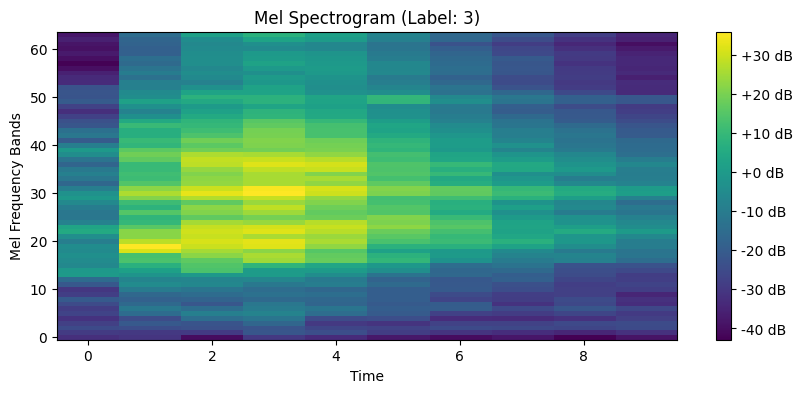

In [15]:
# The mel spectrogram is already computed in the __getitem__ method
mel_spec = signal

# Convert the Mel spectrogram to decibels for better visualization
mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db.squeeze().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram (Label: {label})')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.colorbar(format='%+2.0f dB')
plt.show()

